---

# Unsupervised Machine Learning Approach
## Methodology:  HDBSCAN 
###  Univariate Temperature Data
---

**READ**  -  I've created a python script to allow the user to click the button and then they can either have all of the underyling code shown, OR they can just look at the raw output (charts, plots, whatever).  
As you know, sometimes these notebooks contain a fair amount of code... and sometimes folks just want the _results_... here is an [example](https://nbviewer.jupyter.org/urls/gist.github.com/masnick/d6a1af14812c0c4b3314/raw/f7a5abfb6475e683a90b4ac3491d134ef604e460/test.ipynb)

Code defaults to NOT showing any code, so click the toggle button to view the show the underlying code...

In [1]:
# %load toggle.py
# allows code to be hidden, unhidden on jupyter notebook
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide All Notebook Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });</script><form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show All Notebook Code"></form>''')

<br>

```Import standard python libraries```

In [2]:
import warnings
warnings.filterwarnings("ignore")
# import matplotlib.cbook
# warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import pickle
import datetime
import multiprocessing as mp
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('dark_background')
# default start, but later you can change if you desire 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [27]:
import sklearn.datasets as data
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
import hdbscan

It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters

```Change directories to read in file```

In [5]:
%cd D:\ABSOLUTELY_CRITICAL_BACKUP_FOLDER_LOCATION\

D:\ABSOLUTELY_CRITICAL_BACKUP_FOLDER_LOCATION


```Read in data (parquet saved and exported file from previous notebook```

In [6]:
# tsys01 sensor temp values
import fastparquet
pf = pd.read_parquet('tsys.parquet', engine='fastparquet')

```Convert temperature variable from C to F```

In [7]:
# F = C×(9/5)+32
pf['value_hrf'] = pf['value_hrf'].apply(lambda x: (9/5)*x + 32)

In [8]:
pf.head(10)

,sensor,parameter,value_hrf
timestamp,,,
2019-01-01 00:00:03,tsys01,temperature,40.640
2019-01-01 00:00:28,tsys01,temperature,40.496
2019-01-01 00:00:53,tsys01,temperature,40.406
2019-01-01 00:01:18,tsys01,temperature,40.424
2019-01-01 00:01:43,tsys01,temperature,40.478
2019-01-01 00:02:08,tsys01,temperature,40.424
2019-01-01 00:02:33,tsys01,temperature,40.334
2019-01-01 00:02:58,tsys01,temperature,40.496
2019-01-01 00:03:23,tsys01,temperature,40.424


In [9]:
pf.tail(10)

,sensor,parameter,value_hrf
timestamp,,,
2019-02-28 23:56:10,tsys01,temperature,31.766
2019-02-28 23:56:35,tsys01,temperature,31.946
2019-02-28 23:57:00,tsys01,temperature,32.018
2019-02-28 23:57:25,tsys01,temperature,31.820
2019-02-28 23:57:50,tsys01,temperature,31.784
2019-02-28 23:58:15,tsys01,temperature,31.946
2019-02-28 23:58:40,tsys01,temperature,32.270
2019-02-28 23:59:05,tsys01,temperature,32.144
2019-02-28 23:59:30,tsys01,temperature,32.090


In [10]:
print('\nNumber of rows of data ........', f'{len(pf):,}')


Number of rows of data ........ 203,481


In [11]:
# date range
print('\nStart .....', pf.head(1).index[0])
print('\nEnd .......', pf.tail(1).index[0])


Start ..... 2019-01-01 00:00:03

End ....... 2019-02-28 23:59:55


In [12]:
tsys = pf.copy()
# look at notebook 201, we filtered all the way to 
# tsys01 level, my imported data (parquet) already
# assumes that was all done, so for clarity, renaming
# pf to the tsys equivalent from 201...

In [13]:
tsys.head(10)

,sensor,parameter,value_hrf
timestamp,,,
2019-01-01 00:00:03,tsys01,temperature,40.640
2019-01-01 00:00:28,tsys01,temperature,40.496
2019-01-01 00:00:53,tsys01,temperature,40.406
2019-01-01 00:01:18,tsys01,temperature,40.424
2019-01-01 00:01:43,tsys01,temperature,40.478
2019-01-01 00:02:08,tsys01,temperature,40.424
2019-01-01 00:02:33,tsys01,temperature,40.334
2019-01-01 00:02:58,tsys01,temperature,40.496
2019-01-01 00:03:23,tsys01,temperature,40.424


In [14]:
tsys.tail(10)

,sensor,parameter,value_hrf
timestamp,,,
2019-02-28 23:56:10,tsys01,temperature,31.766
2019-02-28 23:56:35,tsys01,temperature,31.946
2019-02-28 23:57:00,tsys01,temperature,32.018
2019-02-28 23:57:25,tsys01,temperature,31.820
2019-02-28 23:57:50,tsys01,temperature,31.784
2019-02-28 23:58:15,tsys01,temperature,31.946
2019-02-28 23:58:40,tsys01,temperature,32.270
2019-02-28 23:59:05,tsys01,temperature,32.144
2019-02-28 23:59:30,tsys01,temperature,32.090


# A) Initial Examination into HDBSCAN:

In [15]:
# after this, will grab a much larger dataset

In [16]:
tsys.dtypes

sensor       category
parameter    category
value_hrf     float64
dtype: object

In [17]:
len(tsys)

203481

In [18]:
X = tsys['value_hrf'].copy()
# X[:10]
# X.values[:10]
# Utilize standard scaler 
X = StandardScaler().fit_transform(X.values.reshape(-1,1))

In [19]:

clusterer= hdbscan.HDBSCAN(min_cluster_size=25, 
                           prediction_data=True, 
                           gen_min_span_tree=True)
clusterer.fit(X)


HDBSCAN(gen_min_span_tree=True, min_cluster_size=25, prediction_data=True)

```printing out relevant data:```

In [20]:
clusterer.get_params()

{'algorithm': 'best',
 'allow_single_cluster': False,
 'alpha': 1.0,
 'approx_min_span_tree': True,
 'cluster_selection_epsilon': 0.0,
 'cluster_selection_method': 'eom',
 'core_dist_n_jobs': 4,
 'gen_min_span_tree': True,
 'leaf_size': 40,
 'match_reference_implementation': False,
 'memory': Memory(location=None),
 'metric': 'euclidean',
 'min_cluster_size': 25,
 'min_samples': None,
 'p': None,
 'prediction_data': True}


HDBSCAN is noise aware – it has a notion of data samples that are not assigned to any cluster. (handled by assigning these samples the label -1)

The hdbscan library implements soft clustering, where each data point is assigned a cluster membership score ranging from 0.0 to 1.0. 

A score of 0.0 represents a sample that is not in the cluster at all (all noise points will get this score) while a score of 1.0 represents a sample that is at the heart of the cluster (note that this is not the spatial centroid notion of core). You can access these scores via the probabilities_ attribute.


```python
 hdbscan_methods = ['algorithm',
 'allow_single_cluster',
 'alpha',
 'approx_min_span_tree',
 'cluster_persistence_',
 'cluster_selection_epsilon',
 'cluster_selection_method',
 'condensed_tree_',
 'core_dist_n_jobs',
 'exemplars_',
 'fit',
 'fit_predict',
 'gen_min_span_tree',
 'generate_prediction_data',
 'get_params',
 'labels_',
 'leaf_size',
 'match_reference_implementation',
 'memory',
 'metric',
 'min_cluster_size',
 'min_samples',
 'minimum_spanning_tree_',
 'outlier_scores_',
 'p',
 'prediction_data',
 'prediction_data_',
 'probabilities_',
 'relative_validity_',
 'set_params',
 'single_linkage_tree_',
 'weighted_cluster_centroid',
 'weighted_cluster_medoid']
    ```
    

```

hdbscan.dist_metrics.METRIC_MAPPING (output):
---------------------------------------------
braycurtis hdbscan.dist_metrics.BrayCurtisDistance
canberra hdbscan.dist_metrics.CanberraDistance
chebyshev hdbscan.dist_metrics.ChebyshevDistance
cityblock hdbscan.dist_metrics.ManhattanDistance
dice hdbscan.dist_metrics.DiceDistance
euclidean hdbscan.dist_metrics.EuclideanDistance
hamming hdbscan.dist_metrics.HammingDistance
haversine hdbscan.dist_metrics.HaversineDistance
infinity hdbscan.dist_metrics.ChebyshevDistance
jaccard hdbscan.dist_metrics.JaccardDistance
kulsinski hdbscan.dist_metrics.KulsinskiDistance
l1 hdbscan.dist_metrics.ManhattanDistance
l2 hdbscan.dist_metrics.EuclideanDistance
mahalanobis hdbscan.dist_metrics.MahalanobisDistance
manhattan hdbscan.dist_metrics.ManhattanDistance
matching hdbscan.dist_metrics.MatchingDistance
minkowski hdbscan.dist_metrics.MinkowskiDistance
p hdbscan.dist_metrics.MinkowskiDistance
pyfunc hdbscan.dist_metrics.PyFuncDistance
rogerstanimoto hdbscan.dist_metrics.RogersTanimotoDistance
russellrao hdbscan.dist_metrics.RussellRaoDistance
seuclidean hdbscan.dist_metrics.SEuclideanDistance
sokalmichener hdbscan.dist_metrics.SokalMichenerDistance
sokalsneath hdbscan.dist_metrics.SokalSneathDistance
wminkowski hdbscan.dist_metrics.WMinkowskiDistance
```

In [21]:
for item in clusterer.get_params().items(): print(item[0], '...............', item[1])  

algorithm ............... best
allow_single_cluster ............... False
alpha ............... 1.0
approx_min_span_tree ............... True
cluster_selection_epsilon ............... 0.0
cluster_selection_method ............... eom
core_dist_n_jobs ............... 4
gen_min_span_tree ............... True
leaf_size ............... 40
match_reference_implementation ............... False
memory ............... Memory(location=None)
metric ............... euclidean
min_cluster_size ............... 25
min_samples ............... None
p ............... None
prediction_data ............... True


---

In [31]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<AxesSubplot:ylabel='distance'>

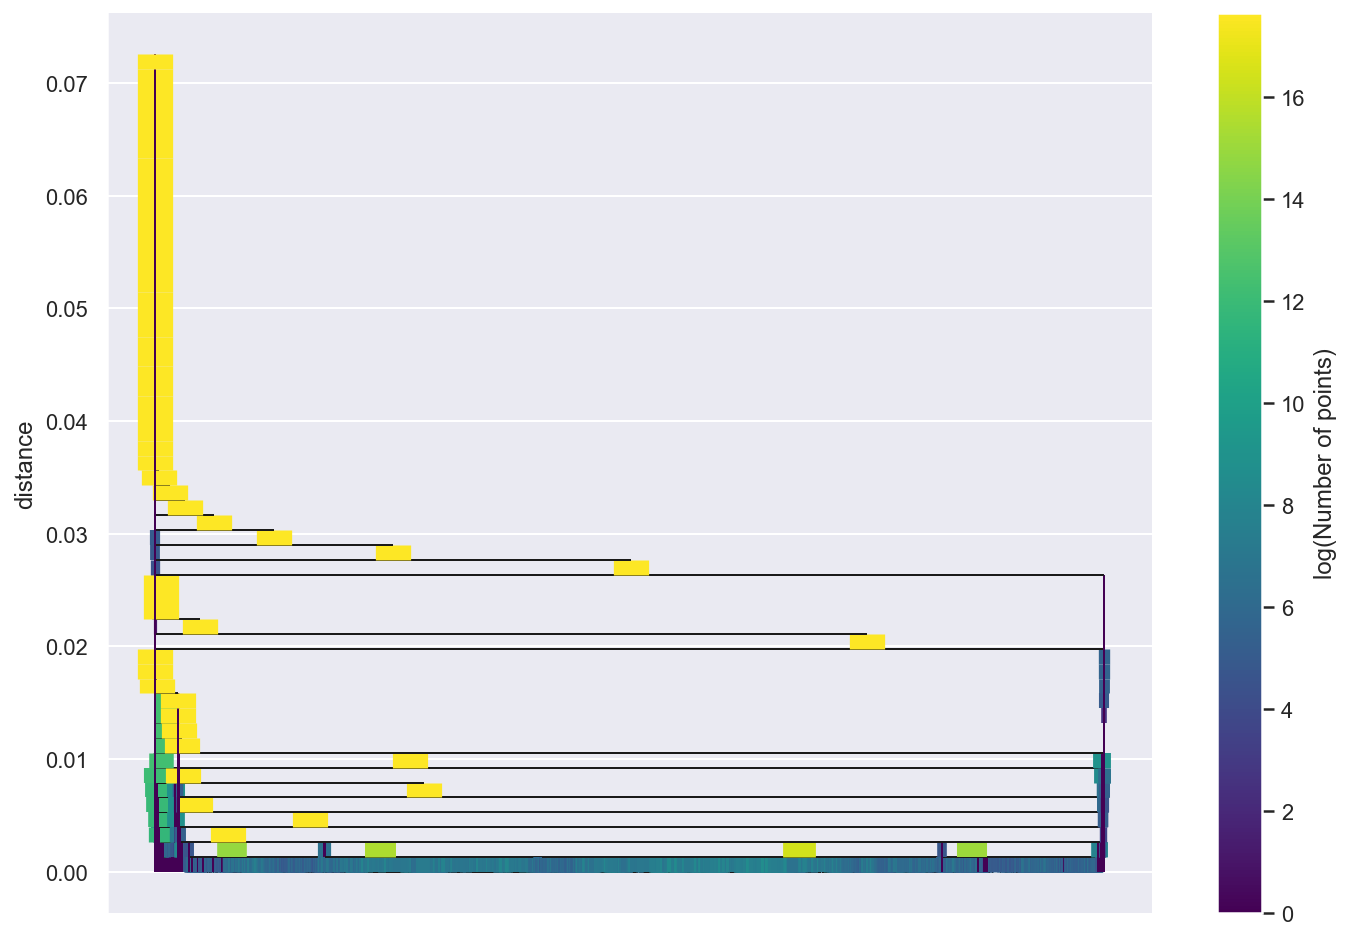

In [32]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<AxesSubplot:ylabel='$\\lambda$ value'>

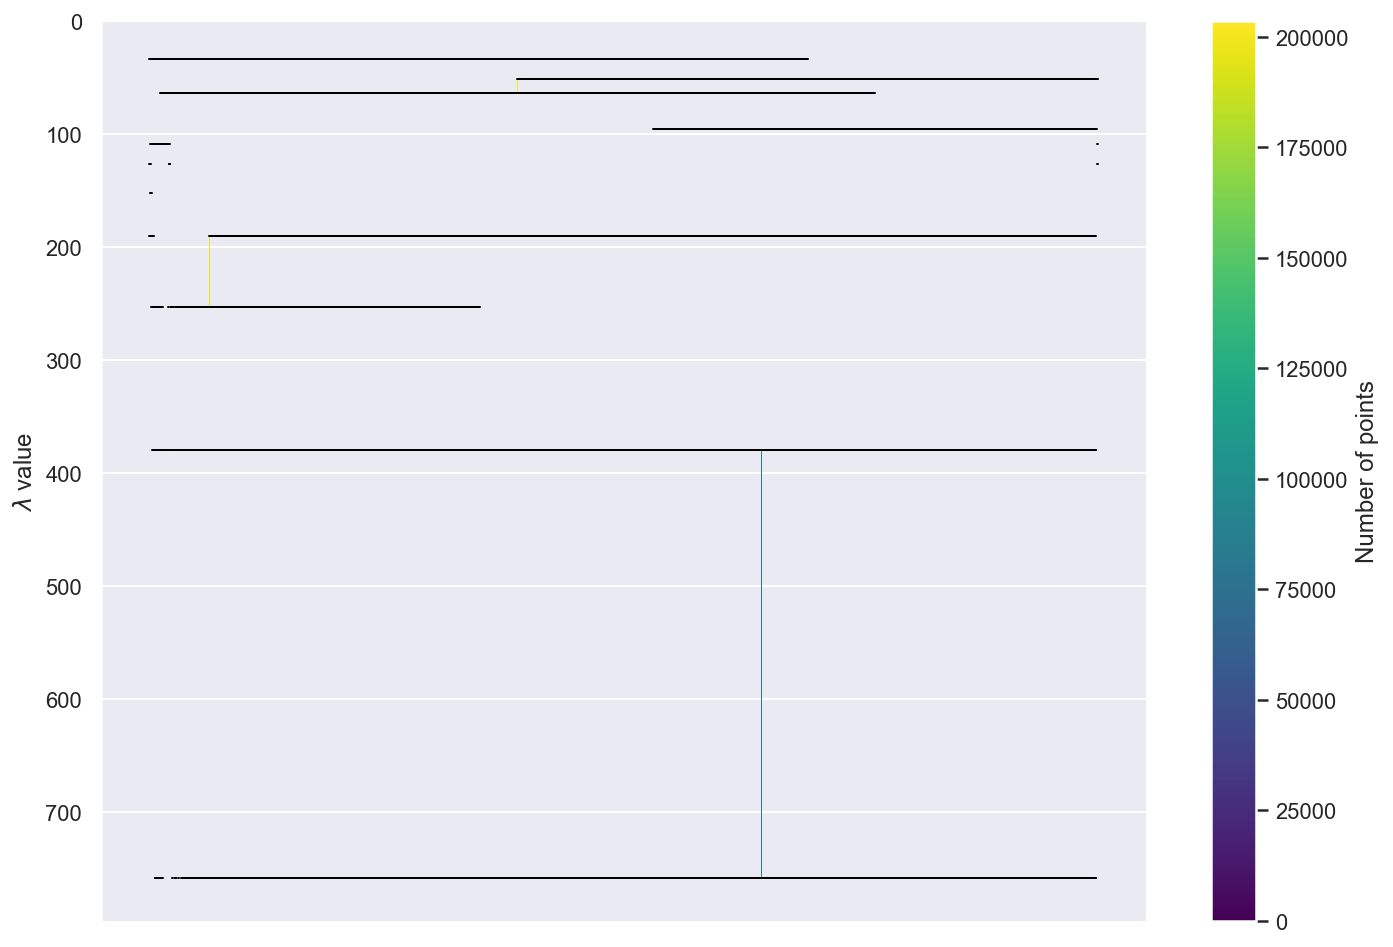

In [33]:
clusterer.condensed_tree_.plot()

<AxesSubplot:ylabel='$\\lambda$ value'>

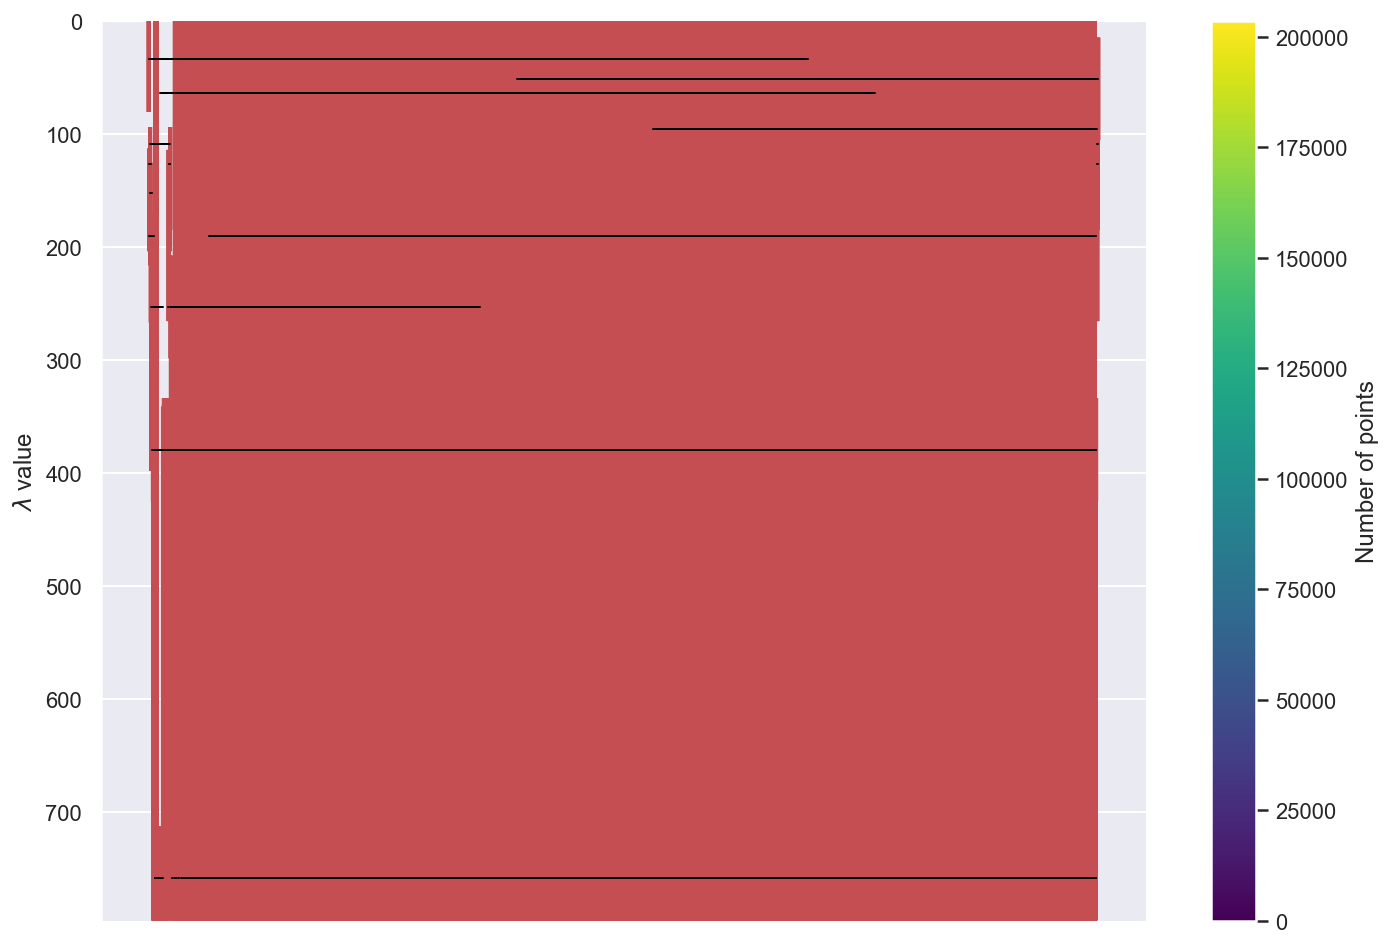

In [34]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [35]:
print(clusterer.probabilities_)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

# Previously tuned parameters, but for now really just looking around
myeps = .01
myminsamples = 25
#************************************************************************************
db = DBSCAN(eps=myeps, min_samples=myminsamples, metric='euclidean', n_jobs=-1).fit(X)
#************************************************************************************

# db.get_params(deep=True)
# {'algorithm': 'auto',
#  'eps': 0.01,
#  'leaf_size': 30,
#  'metric': 'euclidean',
#  'metric_params': None,
#  'min_samples': 25,
#  'n_jobs': -1,
#  'p': None}

label=db.labels_
#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)
sample_cores[db.core_sample_indices_]=True
# Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print(myeps,myminsamples)
print('\nNo of clusters:',n_clusters, '\n')
# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')
tsys["cluster"] = db.labels_
print(tsys["cluster"].value_counts(), '\n')
#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()
# tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()

In [ ]:
# plt.figure(figsize=(22, 9))
# plt.plot(tsys.index, tsys.value_hrf, 'cyan', markersize=1, linewidth=.9, label="temp sensor")
# plt.ylabel('Temperature F°')
# plt.box(False)
# plt.title(r'Temperature Data - Chicago Sensor (time window: 1Q 2019,  lat/lon: 41.751295,87.605288,  node location identifier: 001e0610ee36,  subsensor identifier: tsys01)')
# plt.grid(axis='y', color='grey', linestyle='-', linewidth=.5, alpha=.8)
# plt.locator_params(axis='y', nbins=10)
# plt.tight_layout()
# plt.show();
# # plt.savefig('single_subsensor_temp_data_plotted_two_months.png', dpi=600)

In [ ]:
# # PYTHONIC: kill a column IF it exits already 
# # (so no warning/errrors stopping us)
# thisFilter = tsys.filter('cluster')
# tsys.drop(thisFilter, inplace=True, axis=1)
# # tsys.drop('cluster', axis=1, inplace=True)  
# # if you iterate, you need to remove ! 

In [ ]:
X = tsys['value_hrf'].copy()
# X[:10]
# X.values[:10]
# Utilize standard scaler 
X = StandardScaler().fit_transform(X.values.reshape(-1,1))

In [ ]:
plt.style.use('default')
plt.figure(figsize=(20, 4))
plt.plot(tsys.index, X, 'grey', markersize=1, linewidth=.9)
plt.box(False)
print("Standard Scaler View of Data (normalized):")
plt.show();
# normalized 

STOP and think:
 - I need a gridsearch type method for my dbscan eps/min_samples to determine the repercussion to cluster size and count, what is pertinent and what isn't, and generalized behavior as eps/min_samples variables fluctuate

```-- DBSCAN Gridsearch 1 --
       Running DBSCAN on the raw data and varying eps/min_samples hyperparameters to determine outcome```

In [ ]:
# UNUSUAL:
# IT RUNS FASTER ! 

#### I previously ran this...

In [ ]:
# careful, make sure you remove the sys.stdout or you won't see anything 
# later ! ! ! 

In [ ]:

# import sys

# # THIS IS REALLY CHECKING A HUGE MUMBER OF VARIATIONS...

# eps_range = [.02]

# # , .02, .03, .04, .05, .06, .07, .08, 
# #              .09, .10, .11, .12, .13, .14, .15, .16, 
# #              .17, .18, .19, .20]

# min_samples_range = [3, 4, 5, 6, 7, 8, 9, 10, 11, 
#                      12, 13, 14, 15, 16, 17, 18, 
#                      19, 20, 21, 22, 23, 24, 25]

# sys.stdout = open('D:\dbscan_gridsearch_02.txt','wt')

# print('Tom Bresee:')
# print('')
# print('eps range:')
# print(eps_range)
# print('')
# print('min_samples range:')
# print(min_samples_range)
# print('')

# for i in eps_range:
#     for j in min_samples_range:
#         print('--- NEW VARIABLE ---')
#         db = DBSCAN(eps=i, min_samples=j, metric='euclidean', n_jobs=-1).fit(X)
#         label=db.labels_
#         sample_cores=np.zeros_like(label,dtype=bool)
#         sample_cores[db.core_sample_indices_]=True
#         n_clusters=len(set(label))- (1 if -1 in label else 0)
#         print('eps:', i, "  min_samples:", j)
#         print('Cluster Count:',n_clusters)
#         tsys["cluster"] = db.labels_
#         print(tsys["cluster"].value_counts(), '\n')
#         print("")
        

In [ ]:
# i think eps of 0.1 is WAY TOO BIG 

In [ ]:

# eps_range = [.003]

# min_samples_range = [3, 4, 5, 6, 7, 8, 9, 10, 11, 
#                      12, 13, 14, 15, 16, 17, 18, 
#                      19, 20, 21, 22, 23, 24, 25, 50, 100, 150]

# sys.stdout = open('D:\dbscan_gridsearch_04.txt','wt')

# print('')
# print('eps range:')
# print(eps_range)
# print('')
# print('min_samples range:')
# print(min_samples_range)
# print('')

# for i in eps_range:
#     for j in min_samples_range:
#         print('--- NEW VARIABLE ---')
#         db = DBSCAN(eps=i, min_samples=j, metric='euclidean', n_jobs=-1).fit(X)
#         label=db.labels_
#         sample_cores=np.zeros_like(label,dtype=bool)
#         sample_cores[db.core_sample_indices_]=True
#         n_clusters=len(set(label))- (1 if -1 in label else 0)
#         print('eps:', i, "  min_samples:", j)
#         print('Cluster Count:',n_clusters)
        
#         tsys["cluster"] = db.labels_
#         print(tsys["cluster"].value_counts(), '\n')
#         print("")
        

<BR>

In [ ]:
neighbors = NearestNeighbors(n_neighbors=500)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [ ]:
type(neighbors)

In [ ]:
# neighbors attributes:
#  'algorithm',
#  'effective_metric_',
#  'effective_metric_params_',
#  'fit',
#  'get_params',
#  'kneighbors',
#  'kneighbors_graph',
#  'leaf_size',
#  'metric',
#  'metric_params',
#  'n_features_in_',
#  'n_jobs',
#  'n_neighbors',
#  'n_samples_fit_',
#  'p',
#  'radius',
#  'radius_neighbors',
#  'radius_neighbors_graph',
#  'set_params'

In [ ]:
neighbors.get_params()

In [ ]:
neighbors.algorithm

In [ ]:
neighbors.effective_metric_

In [ ]:
neighbors.n_samples_fit_

In [ ]:
#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

# Previously tuned parameters, but for now really just looking around
myeps = .01
myminsamples = 25
#************************************************************************************
db = DBSCAN(eps=myeps, min_samples=myminsamples, metric='euclidean', n_jobs=-1).fit(X)
#************************************************************************************

# db.get_params(deep=True)
# {'algorithm': 'auto',
#  'eps': 0.01,
#  'leaf_size': 30,
#  'metric': 'euclidean',
#  'metric_params': None,
#  'min_samples': 25,
#  'n_jobs': -1,
#  'p': None}

label=db.labels_
#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)
sample_cores[db.core_sample_indices_]=True
# Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print(myeps,myminsamples)
print('\nNo of clusters:',n_clusters, '\n')
# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')
tsys["cluster"] = db.labels_
print(tsys["cluster"].value_counts(), '\n')
#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()
# tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()

```-- ITERATION 1 --
       Plotting the clusters that DBSCAN identified, with our base eps and min_samples hyperparameters:```

In [ ]:
# AAA.  DO NOT LOSE THIS CODE, WORKING ! 

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)
plt.ylabel('Temperature F°')
# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.title('Sensor Temperature Data Anomalies, 1Q-2019, node location identifier: 001e0610ee36, subsensor identifier: tsys01, lat/lon: 41.751295,87.605288, [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples), 
         fontsize=14)
# plt.legend()
plt.legend(loc='upper center', fontsize=15)
plt.tight_layout()
plt.box(False)
plt.show();
# these results have been saved, comment out now be careful
# plt.savefig('dbr_1.png', dpi=800); 

```-- ITERATION 1 --
       Translating / Understanding what we are seeing with anomaly detection:```

In [ ]:
# BBB. DO NOT LOSE THIS CODE, WORKING

# plt.style.use('seaborn-ticks')
plt.style.use('default')

# plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
fig, ax = plt.subplots(figsize=(30,8))
# plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
# plt.style.use('white_background')
plt.plot(tsys.index, tsys.value_hrf, color = 'grey', alpha = .7, markersize=.8, linewidth=.9, label="temperature readings")

# --- original code 
# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']
# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=20, alpha=0.9)

# c = tsys.loc[tsys['cluster'] == 1].index
# d= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=20, alpha=0.9)

# e = tsys.loc[tsys['cluster'] == 2].index
# f= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=20, alpha=0.9)

# g = tsys.loc[tsys['cluster'] == 3].index
# h= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 3', s=20, alpha=0.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']
# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

# c = tsys.loc[tsys['cluster'] == 3].index
# d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# ax.annotate('local maximum', xy=('2019-01-01', 10), xytext=('2019-01-29', 5),
#             color="white", arrowprops=dict(facecolor='green', shrink=0.05))

# ax.annotate("Independence Day", xy=('2019-01-29', -20),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             xytext=(10, -40), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

ax.annotate("IDENTIFIED: UNUSUALLY HIGH WINTER TEMPS", xy=(pd.Timestamp('2019-01-06'), 60),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="red"),
            xytext=(150,0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate("POLAR VORTEX STORM HITS CHICAGO !", xy=(pd.Timestamp('2019-01-30'), -13),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="blue"),
            xytext=(-140, 0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate("'Predecessor' Triggers", xy=(pd.Timestamp('2019-02-01'), -7),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="yellow"),
            xytext=(125, 25), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html
plt.title('Chicago Sensor Data Anomalies (Unsupervised Machine Learning):  timerange: 1Q-2019, node location identifier: 001e0610ee36, subsensor identifier: tsys01, address: Cottage Grove Ave & 79th St Chicago IL, lat/lon: 41.751295,87.605288, [alg=DBSCAN, eps={0}, min_samples={1}, cluster_count:4]'.format(myeps, myminsamples), 
         fontsize=12)
plt.grid(axis='y', color='grey', linestyle='--', linewidth=.5, alpha=.3)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=20)
plt.legend(loc='upper center', fontsize=12)
plt.ylabel('Temperature F°')
plt.box(False)
plt.tight_layout()
plt.show(); 
# plt.savefig('pow.png', dpi=800) # single_subsensor_temp_data_two_month_dbscan_clusters.png', dpi=600)
# plt.savefig('delta2.png', facecolor = 'white', dpi=600)
# plt.savefig('temp2.png', facecolor="black", edgecolor="none")

```-- ITERATION 1 --
       Visualizing some closeup ranges (red anomaly and blue anomaly regions):```

In [ ]:
# ccc.  WINDOWS AND RANGES

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 6))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1.5, linewidth=1.6)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=52, alpha=0.66)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

# ax.annotate("POLAR VORTEX STORM HITS CHICAGO !", xy=(pd.Timestamp('2019-01-05 21:00:00'), 60),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="blue"),
#             xytext=(-140, 0), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)
plt.ylabel('Temperature F°')
# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.title('CLOSEUP (January 5th, 8:04 PM - 9:40 PM)  -  Anomalous High Temperature Readings Identified via Unsupervised Machine Learning (DBSCAN)  [Chicago Sensor 1, 25s granularity]'.format(myeps, myminsamples), 
         fontsize=14)
# plt.legend()
# plt.legend(loc='center', fontsize=15)

plt.xlim(pd.Timestamp('2019-01-05 20:04:00'), pd.Timestamp('2019-01-05 21:41:00'))

plt.ylim((50, 66))
# @#pd.Timestamp('2019-01-05 19:59:20'), pd.Timestamp('2019-01-05 21:26:33'))

plt.tight_layout()
plt.box(False)
plt.show();
# these results have been saved, comment out now be careful
# plt.savefig('dbr_1_r1.png', dpi=800); 

In [ ]:
# secondary window

plt.style.use('seaborn-ticks')
plt.figure(figsize=(24, 11))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1.5, linewidth=.7)

# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']
# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=52, alpha=0.66)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Cluster 3', s=5, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Cluster 1', s=50, alpha=0.6)

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Cluster 2', s=50, alpha=0.6)
plt.ylabel('Temperature F°')
# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.title('CLOSEUP (January 30th-31st, 2019) - Anomalous Low Temperature Readings Identified via Unsupervised Machine Learning (DBSCAN)  [Chicago Sensor 1, 25s granularity]'.format(myeps, myminsamples), 
         fontsize=14)
# plt.legend()
plt.legend(loc='lower left', fontsize=15)

plt.xlim(pd.Timestamp('2019-01-30 05:09:00'), pd.Timestamp('2019-01-31 17:01:00'))

plt.ylim((-26,-2))
# @#pd.Timestamp('2019-01-05 19:59:20'), pd.Timestamp('2019-01-05 21:26:33'))

plt.tight_layout()
plt.box(False)
plt.show();
# these results have been saved, comment out now be careful
# plt.savefig('dbr_1_r2e.png', dpi=700); 

```As a reference, we use plotly to show all the temperature values over the entire range, 
so readers can home in on the window they wish to view/explore...```

In [ ]:
import plotly.express as px
# fig = px.scatter(tsys, x=tsys.index, 
#                  y=tsys.value_hrf, 
#                  title="1Q 2019 - Chicago Sensor 1 - Raw Data (Temperature in F)", 
#                         template = "plotly_dark").update_traces(marker=dict(size=1,
#                               line=dict(width=.5,
#                                         color='darkgrey')),
#                   selector=dict(mode='markers')).update_layout(yaxis_title="Temperature F°")
# fig.write_html("temp_1q_2019_chicago.html")
# fig.show()
# Uncomment everything out, and it will show the following (via url):

> https://ghcdn.rawgit.org/tombresee/SensorAnalysis/main/ENTER/results/temp_1q_2019_chicago.html

```-- ITERATION 1 --
       Outputting and exporting the actual anomalous values (ranges), and plotting shaded regions...```

In [ ]:
# adding shade !!!!!!!!!!!!

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

print('\nANOMALOUS REGION ("RED", Cluster -1):')
print('(can export to .txt if desired)')


# for date in a.values:
#     print(a)
for c in range(140):
    print(a[c])
    # print(a[0])
    # print(a[1])

min_a = a.min()
max_a = a[-9]
print("")
print('Red Window Start:', min_a)
print('Red Window End:  ', max_a)
print("")
plt.axvspan(min_a, max_a, alpha=.3, color='red')

# line1 = min_a
# line2 = max_a
# ax.axvspan(line1, line2, alpha=.7, color='red')

# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

print('ARCTIC POLAR VORTEX:')
min_c = c.min()
max_c = c.max()
print('Dominant Blue Window Start:', min_c)
print('Dominant Blue Window End:  ', max_c)

line1 = min_c
line2 = max_c
plt.axvspan(line1, line2, alpha=.3, color='blue')
# plt.axvline(x=0.22058956)


# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

plt.ylabel('Temperature F°')
plt.title('Temp Data Anomalies     1Q-2019     [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples))
# plt.legend(loc='upper center', borderaxespad=0.)
plt.tight_layout()
plt.box(False)

plt.xlim(pd.Timestamp('2019-01-05 20:07:20'), pd.Timestamp('2019-01-31 16:26:33'))
# ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))

plt.show();

# plt.savefig('dbrun_1.png', dpi=800);

In [ ]:
# # BBB. DO NOT LOSE THIS CODE, WORKING

# plt.style.use('seaborn-ticks')

# fig, ax = plt.subplots(figsize=(30,8))
# # plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
# # plt.style.use('white_background')
# plt.plot(tsys.index, tsys.value_hrf, color = 'grey', alpha = .7, markersize=.8, linewidth=.9, label="temp sensor")

# # --- original code 
# # a = tsys.loc[tsys['cluster'] == -1].index
# # b= tsys[(tsys['cluster'] == -1)]['value_hrf']
# # plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=20, alpha=0.9)

# # c = tsys.loc[tsys['cluster'] == 1].index
# # d= tsys[(tsys['cluster'] == 1)]['value_hrf']
# # plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=20, alpha=0.9)

# # e = tsys.loc[tsys['cluster'] == 2].index
# # f= tsys[(tsys['cluster'] == 2)]['value_hrf']
# # plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=20, alpha=0.9)

# # g = tsys.loc[tsys['cluster'] == 3].index
# # h= tsys[(tsys['cluster'] == 3)]['value_hrf']
# # plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 3', s=20, alpha=0.9)


# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']
# plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)

# c = tsys.loc[tsys['cluster'] == 3].index
# d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# # ax.annotate('local maximum', xy=('2019-01-01', 10), xytext=('2019-01-29', 5),
# #             color="white", arrowprops=dict(facecolor='green', shrink=0.05))

# # ax.annotate("Independence Day", xy=('2019-01-29', -20),  xycoords='data',
# #             bbox=dict(boxstyle="round", fc="none", ec="gray"),
# #             xytext=(10, -40), textcoords='offset points', ha='center',
# #             arrowprops=dict(arrowstyle="->"))

# ax.annotate("Unusually High Winter Temps", xy=(pd.Timestamp('2019-01-06'), 60),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="red"),
#             xytext=(130,20), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

# ax.annotate("Polar Vortex Storm Hits Chicago !", xy=(pd.Timestamp('2019-01-30'), -12),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="yellow"),
#             xytext=(-140, 20), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

# # https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html

# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
# plt.grid(axis='y', color='grey', linestyle='--', linewidth=.5, alpha=.3)
# plt.locator_params(axis='y', nbins=10)
# plt.locator_params(axis='x', nbins=20)
# plt.legend(loc='upper center', borderaxespad=0.)
# plt.ylabel('Temperature F°')
# plt.box(False)
# plt.tight_layout()
# plt.show(); 

# # plt.savefig('single_subsensor_temp_data_two_month_dbscan_clusters.png', dpi=600)

In [ ]:
# adding shade !!!!!!!!!!!!

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

print('\nANOMALOUS REGION (Cluster: -1):')
# for date in a.values:
#     print(a)
# for c in range(140):
    # halt for now print(a[c])
    # print(a[0])
    # print(a[1])

min_a = a.min()
max_a = a[-9]
print("")
print('Red Window Start:', min_a)
print('Red Window End:  ', max_a)
print('Plotting below:')
print("")
plt.axvspan(min_a, max_a, alpha=.2, color='red')

# line1 = min_a
# line2 = max_a
# ax.axvspan(line1, line2, alpha=.7, color='red')

# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)


print('\nANOMALOUS REGION (Cluster: 1):\n')

print('ARCTIC POLAR VORTEX:')
min_c = c.min()
max_c = c.max()
print('Dominant Blue Window Start:', min_c)
print('Dominant Blue Window End:  ', max_c)
print('Plotting second below:\n')


line1 = min_c
line2 = max_c
plt.axvspan(line1, line2, alpha=.3, color='blue')
# plt.axvline(x=0.22058956)


# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

plt.ylabel('Temperature F°')
plt.title('Temp Data Anomalies     1Q-2019     [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples))
# plt.legend(loc='upper center', borderaxespad=1)
# plt.tight_layout()
plt.box(False)

plt.xlim(pd.Timestamp('2019-01-05 19:55:00'), pd.Timestamp('2019-01-05 22:00:00'))
# ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))

plt.show();

# plt.savefig('dbrun_1.png', dpi=800);

In [ ]:
# adding shade !!!!!!!!!!!!

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

# print('\nANOMALOUS REGION ("RED", Cluster -1):')
# for date in a.values:
#     print(a)
# for c in range(140):
#     print(a[c])
#     # print(a[0])
#     # print(a[1])

min_a = a.min()
max_a = a[-9]
print("")
# print('Red Window Start:', min_a)
# print('Red Window End:  ', max_a)
print("")
plt.axvspan(min_a, max_a, alpha=.3, color='red')

# line1 = min_a
# line2 = max_a
# ax.axvspan(line1, line2, alpha=.7, color='red')

# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

# print('ARCTIC POLAR VORTEX:')
min_c = c.min()
max_c = c.max()
# print('Dominant Blue Window Start:', min_c)
# print('Dominant Blue Window End:  ', max_c)

line1 = min_c
line2 = max_c
plt.axvspan(line1, line2, alpha=.2, color='blue')
# plt.axvline(x=0.22058956)


# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

plt.ylabel('Temperature F°')
plt.title('Temp Data Anomalies     1Q-2019     [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples))
plt.tight_layout()
plt.box(False)
plt.xlim(pd.Timestamp('2019-01-29 23:07:20'), pd.Timestamp('2019-02-01 00:26:33'))
plt.ylim( (-30, 10))
# pd.Timestamp('2019-01-29 23:07:20'), pd.Timestamp('2019-02-01 00:26:33'))

# ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))
plt.show();

In [ ]:
# miniplot if you wanted: 
# plt.figure(figsize=(20, 20))
# plt.scatter(e, f, color='orange', label = 'Anomaly Cluster 2', s=50, alpha=0.6)
# plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=50, alpha=0.6)
# plt.show();  


---
---

### ITERATE 1:

In [ ]:
#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

myeps = .01
myminsamples = 25
#************************************************************************************
db = DBSCAN(eps=myeps, min_samples=myminsamples, metric='euclidean', n_jobs=-1).fit(X)
#************************************************************************************
# db.get_params(deep=True)
# {'algorithm': 'auto',
#  'eps': 0.01,
#  'leaf_size': 30,
#  'metric': 'euclidean',
#  'metric_params': None,
#  'min_samples': 25,
#  'n_jobs': -1,
#  'p': None}

label=db.labels_
#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)
sample_cores[db.core_sample_indices_]=True
# Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print(myeps,myminsamples)
print('\nNo of clusters:',n_clusters, '\n')
# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')
tsys["cluster"] = db.labels_
print(tsys["cluster"].value_counts(), '\n')
#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()
# tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 8))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='orange', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature F°')
# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.title('Temp Data Anomalies, eps = {}'.format(myeps))

plt.legend()
plt.tight_layout()
plt.box(False)
plt.show();

In [ ]:

# use dark background !!!!!!!!!!!!!!!!!!!!!!

fig, ax = plt.subplots(figsize=(30,8))

# plt.style.use('white_background')
# plt.figure(figsize=(30, 8))

plt.plot(tsys.index, tsys.value_hrf, color = 'grey', alpha = .7, markersize=.8, linewidth=.9, label="temp sensor")

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=20, alpha=0.9)

c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=20, alpha=0.9)

e = tsys.loc[tsys['cluster'] == 2].index
f= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=20, alpha=0.9)

g = tsys.loc[tsys['cluster'] == 3].index
h= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 3', s=20, alpha=0.9)

# ax.annotate('local maximum', xy=('2019-01-01', 10), xytext=('2019-01-29', 5),
#             color="white", arrowprops=dict(facecolor='green', shrink=0.05))

# ax.annotate("Independence Day", xy=('2019-01-29', -20),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             xytext=(10, -40), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

ax.annotate("Unusually High Winter Temps", xy=(pd.Timestamp('2019-01-06'), 60),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="red"),
            xytext=(130,20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate("Polar Vortex Storm Hits Chicago !", xy=(pd.Timestamp('2019-01-30'), -12),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="yellow"),
            xytext=(-140, 20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html

plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.grid(axis='y', color='grey', linestyle='--', linewidth=.5, alpha=.3)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=20)
plt.legend(loc = "upper left")

plt.ylabel('Temperature F°')
plt.box(False)

plt.tight_layout()
# plt.show(); 

plt.savefig('single_subsensor_temp_data_two_month_dbscan_clusters.png', dpi=600)


https://en.wikipedia.org/wiki/January%E2%80%93February_2019_North_American_cold_wave

> https://weatherspark.com/m/14091/2/Average-Weather-in-February-in-Chicago-Illinois-United-States

Five records were set for Chicago for the month of January 2019:
* Record daily snowfall of 5.0 inches on the 28th.
* Record daily minimum temperature of -23 degrees on the 30th.
* Record daily lowest maximum temperature of -10 degrees on the
  30th.
* Record daily minimum temperature of -21 degrees on the 31st.
* Tied daily lowest maximum temperature of 1 degree on the 31st.

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(g, h, color='grey', label = 'Anomaly Cluster 3', s=5, alpha=0.5)
plt.show();  

In [ ]:

# db = DBSCAN(eps=0.01, min_samples=25, metric='euclidean', n_jobs=-1).fit(X)

plt.figure(figsize=(35, 50))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']

e = tsys.loc[tsys['cluster'] == 2].index
f= tsys[(tsys['cluster'] == 2)]['value_hrf']

g = tsys.loc[tsys['cluster'] == 3].index
h= tsys[(tsys['cluster'] == 3)]['value_hrf']

plt.scatter(e, f, color='orange', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)

plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

plt.scatter(g, h, color='black', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature C°')
plt.legend()
plt.box(False)

plt.show();  


In [ ]:
# The lowest temperature at Chicago was -23 degrees observed at Chicago O'Hare International Airport on January 30th.
# The lowest temperature at Rockford was -31 degrees observed at Chicago Rockford International Airport on January 31st. 
# The lowest temperature at NWS Chicago in Romeoville was -24 degrees.  This ties the record set on January 16, 2009.
# The lowest temperature at Chicago Midway Airport 3SW observed was -22 degrees on January 31, 2019. 

In [ ]:

# plt.figure(figsize=(25, 5))

# plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']

# c = tsys.loc[tsys['cluster'] == 1].index
# d= tsys[(tsys['cluster'] == 1)]['value_hrf']

# # e = tsys.loc[tsys['cluster'] == 2].index
# # f= tsys[(tsys['cluster'] == 2)]['value_hrf']
# # plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=35, alpha=0.7)

# plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=35, alpha=0.7)
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=30, alpha=0.5)

# # plt.xlabel('Arrival Date')
# plt.ylabel('Temperature C°')
# plt.legend()
# plt.box(False)

# plt.show();  


In [ ]:

# ORIGINAL CODE BEFORE I USED THE NEW ABOVE 

# label=db.labels_

# from sklearn import metrics

# #identifying the points which makes up our core points
# sample_cores=np.zeros_like(label,dtype=bool)

# sample_cores[db.core_sample_indices_]=True

# # Calculating the number of clusters

# n_clusters=len(set(label))- (1 if -1 in label else 0)

# print('No of clusters:',n_clusters)


* https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

#### Calculating Metrics:

In [ ]:

# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)

# core_samples_mask[db.core_sample_indices_] = True

# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.

# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)

# # print('Estimated number of noise points: %d' % n_noise_)

# # print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))

# # print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))

# # print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))

# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))


In [ ]:
# EVERYTHING BELOW THIS LINE STILL WORKING ON:

### Using Tuning Approach:

In [ ]:

from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=11)

neighbors = nearest_neighbors.fit(X)

distances, indices = neighbors.kneighbors(X)

distances = np.sort(distances[:,10], axis=0)

fig = plt.figure(figsize=(5, 5))

plt.plot(distances)

plt.xlabel("Points")

plt.ylabel("Distance")

plt.savefig("Distance_curve.png", dpi=300)



# Appendix:  Do Not Delete

```python
from sklearn.cluster import DBSCAN
clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(ts_dataframe['Normalized Profit']).reshape(-1,1))

labels = clustering1.labels_

outlier_pos = np.where(labels == -1)[0]

x = []; y = [];
for pos in outlier_pos:
    x.append(np.array(ts_dataframe['Normalized Profit'])[pos])
    y.append(ts_dataframe['Normalized Profit'].index[pos])
    
plt.plot(ts_dataframe['Normalized Profit'].loc[ts_dataframe['Normalized Profit'].index], 'k-')
plt.plot(y,x,'r*', markersize=8)  
plt.legend(['Actual', 'Anomaly Detected'])
plt.xlabel('Time Period')
plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
plt.ylabel('Normalized Profit')
```

In [ ]:
# # Sets the figure size temporarily but has to be set again the next plot
# plt.figure(figsize=(20,16))
# sns.lineplot(x=tdf.index, y="value_hrf", hue="sensor", data=tdf); 
# plt.show()

In [ ]:

# tdf = tdf[tdf['sensor'].isin(['bmp180', 'htu21d', 'pr103j2', 'tsys01'])]


In [ ]:

# Sets the figure size temporarily but has to be set again the next plot
# plt.figure(figsize=(20,16))
# sns.lineplot(x=tdf.index, y="value_hrf", hue="sensor", data=tdf); 
# plt.show()


* dont use:
 * tmp421
 * tmp112
 * hih6130
 

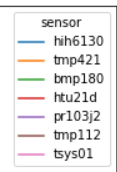

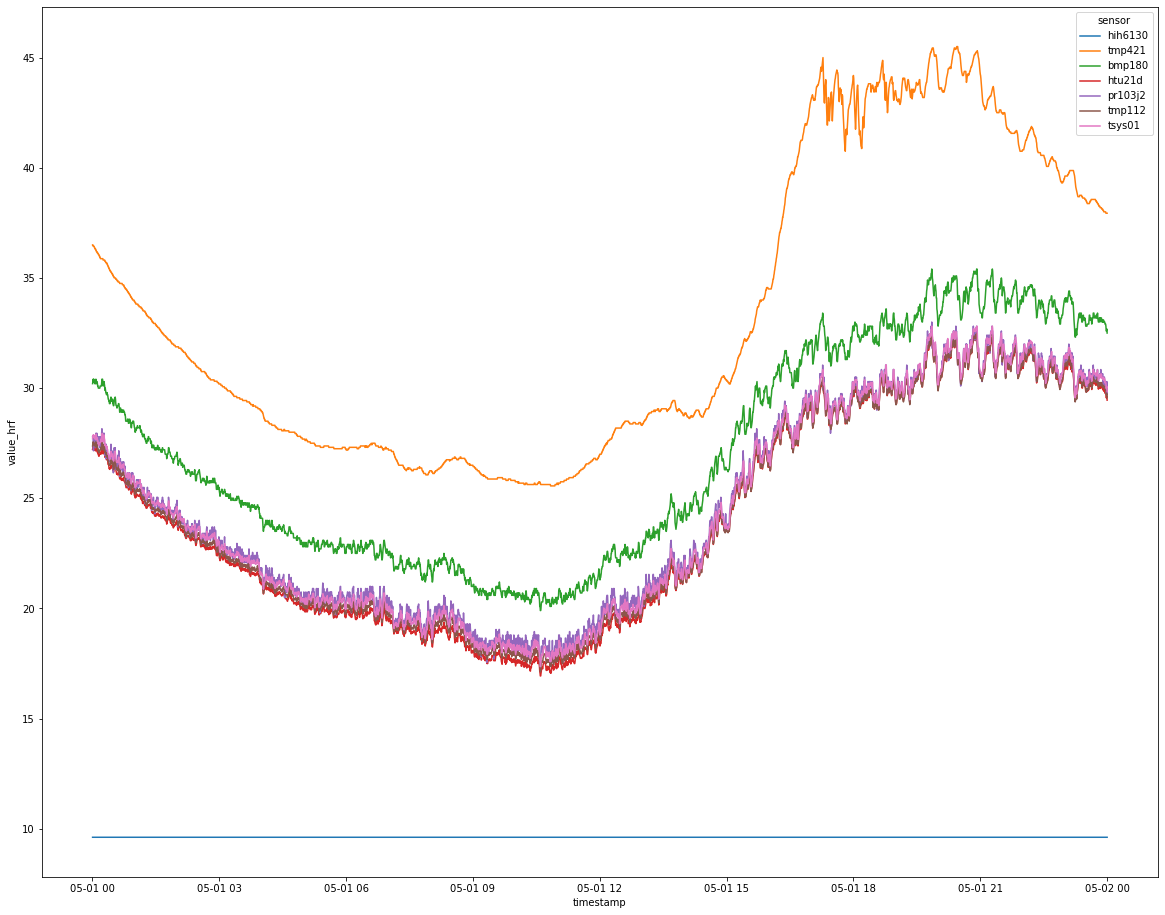

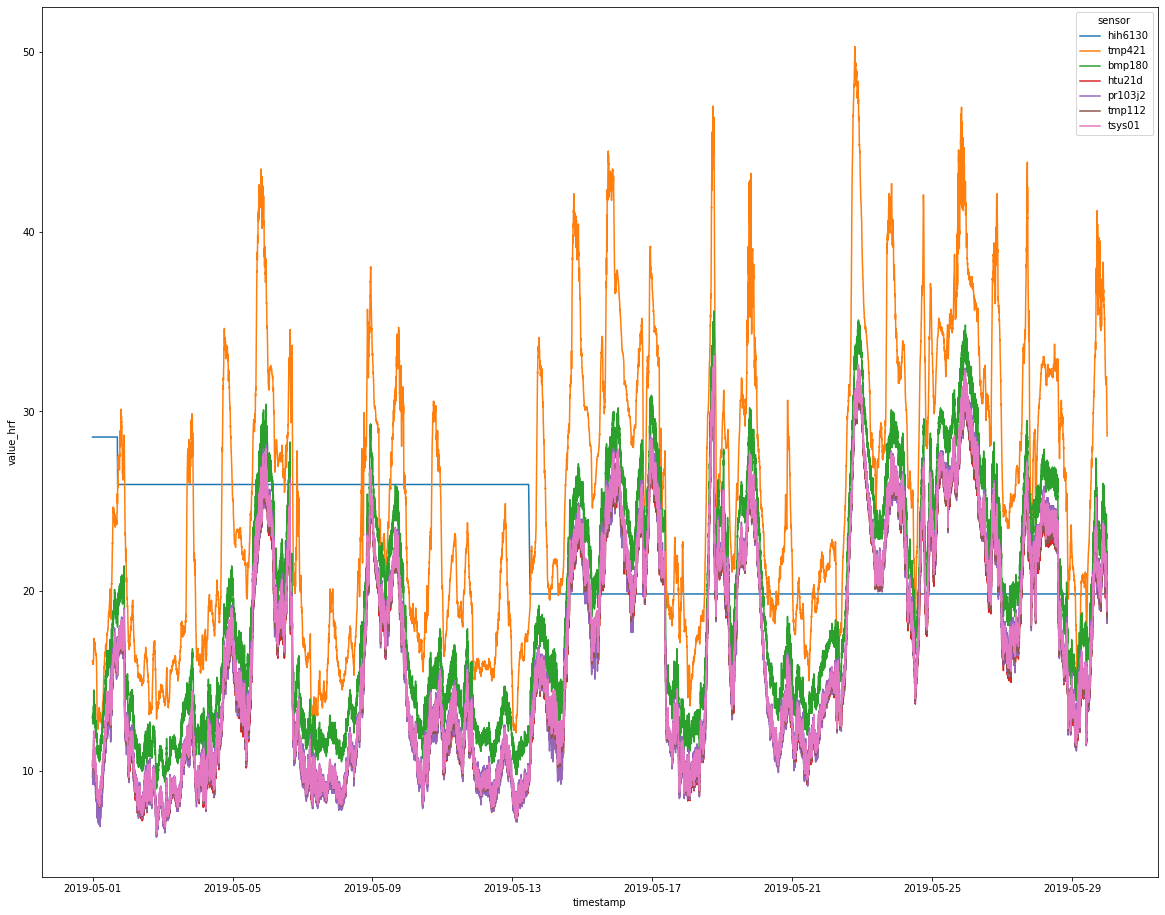

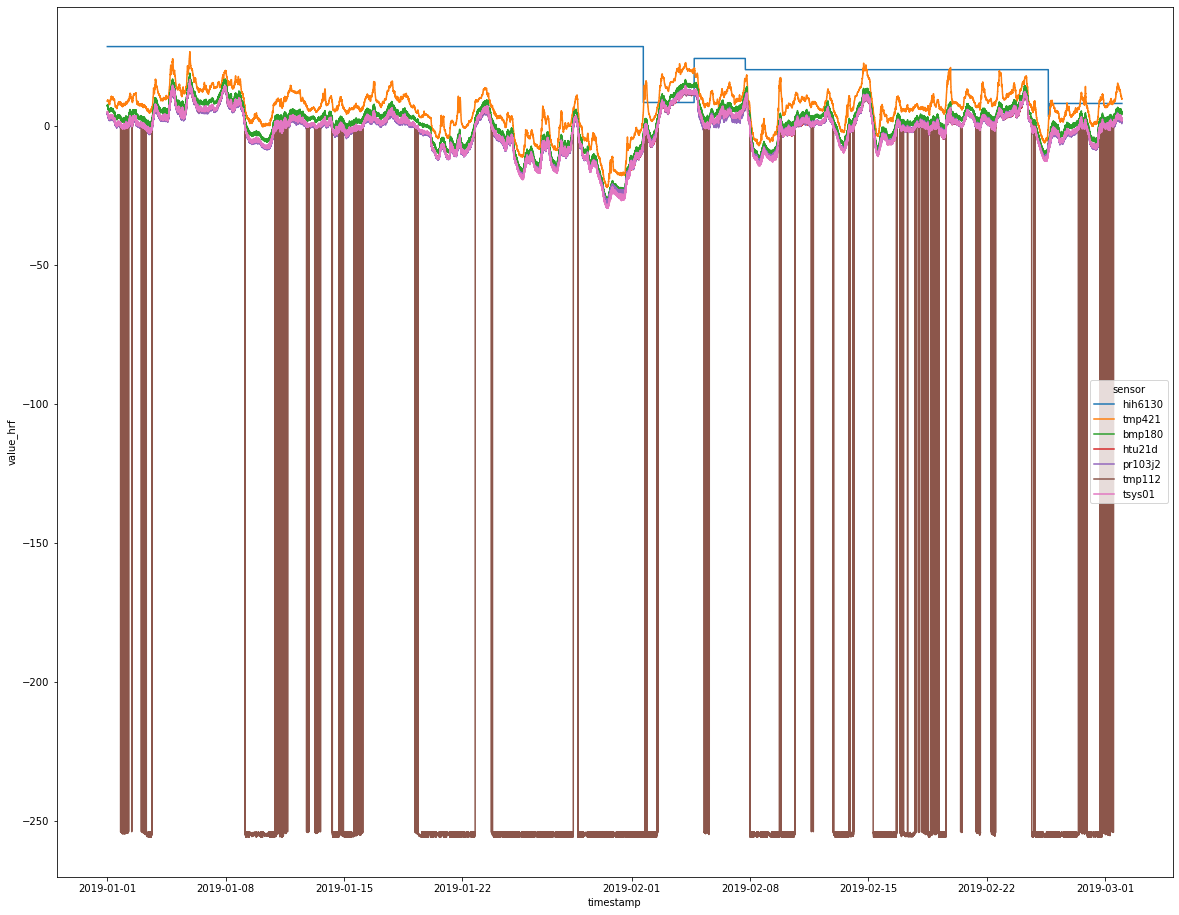

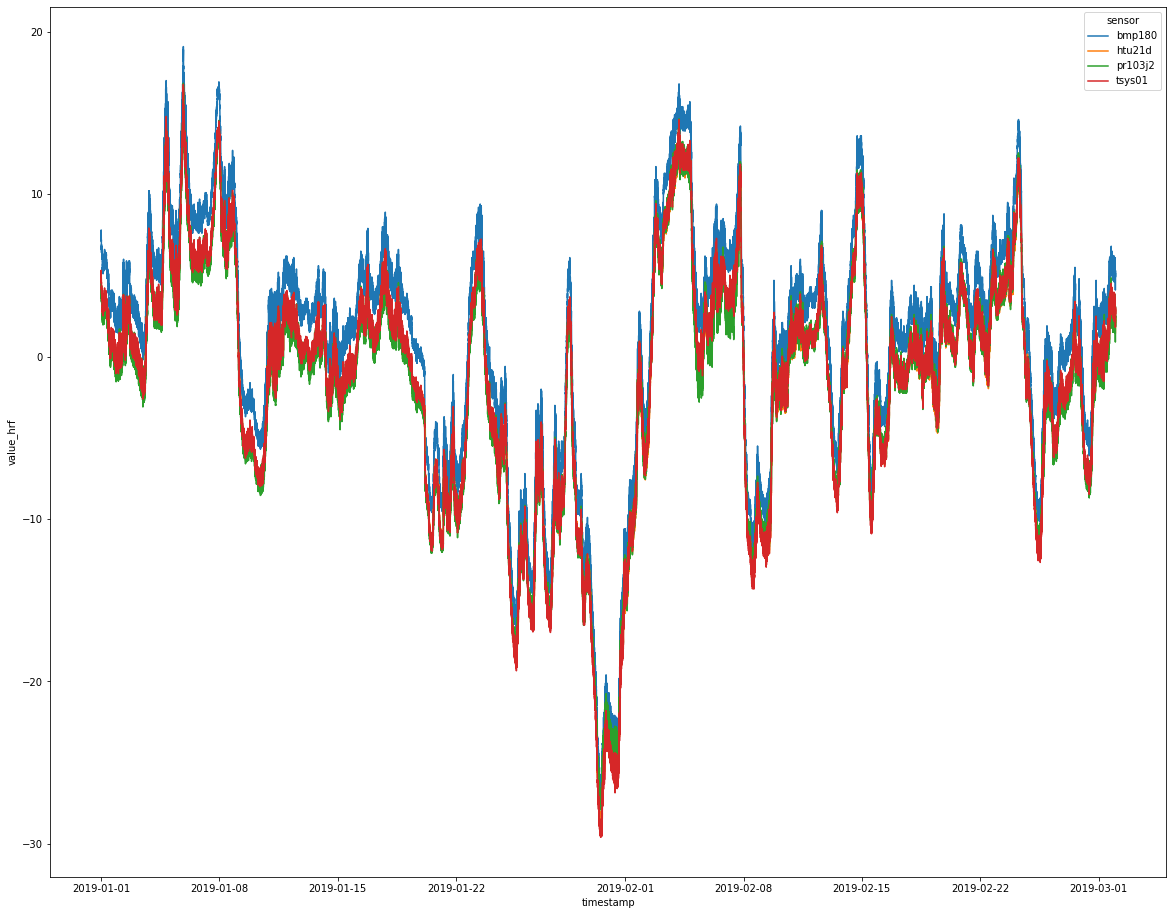

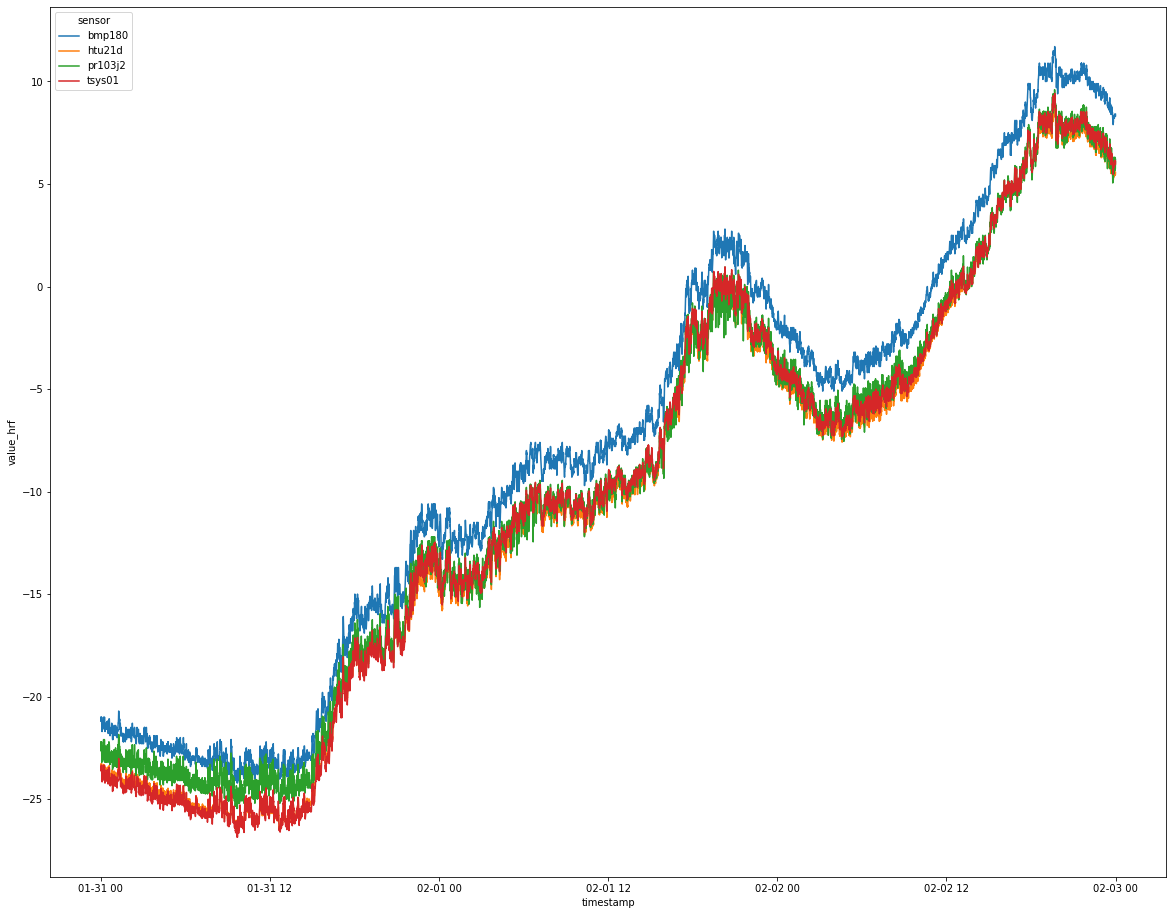

In [ ]:
minidf.head(10)

In [ ]:
len(minidf)

In [ ]:
len(tdf)

In [ ]:
non_tdf = minidf[minidf.parameter != 'temperature'].copy()

In [ ]:
len(non_tdf)

In [ ]:
for p in non_tdf.parameter.unique(): print(p)

In [ ]:

# non_tdf.head(1000)


In [ ]:

# i dont think we necessariry care too much about acceleration data (although its good to have), but 
# maybe lets focus on 


In [ ]:

hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.head(10)

# three sep datavalues ! 


In [ ]:

# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:
hdf.dtypes

In [ ]:

hdf = hdf[hdf['sensor'].isin(['hih4030'])]
# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:

hdf.value_hrf = hdf.value_hrf.astype(np.float16)
hdf = hdf.loc['2019-02-01 03:00':'2019-02-01 04:00'].copy()
# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()



In [ ]:

hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.value_hrf = hdf.value_hrf.astype(np.float16)

hdf = hdf[hdf['sensor'].isin(['hih4030', 'htu21d'])]

hdf = hdf.loc['2019-02-01':'2019-02-12'].copy()
# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:

minidf = df.loc['2019-01-01':'2019-06-01'].copy()
hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.value_hrf = hdf.value_hrf.astype(np.float16)

hdf = hdf[hdf['sensor'].isin(['htu21d'])]
# hdf = hdf.loc['2019-02-01':'2020-02-01'].copy()

# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:

minidf = df.loc['2019-01-01':'2019-06-01'].copy()
hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.value_hrf = hdf.value_hrf.astype(np.float16)

hdf = hdf[hdf['sensor'].isin(['hih4030'])]
# hdf = hdf.loc['2019-02-01':'2020-02-01'].copy()

# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:
# make large numbers more readable by adding commas
# pd.options.display.float_format = '{:,}'.format
# Example
# 123456789.12345 -> 123,456,789.12345



In [ ]:
# from sklearn.cluster import DBSCAN
# clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(ts_dataframe['Normalized Profit']).reshape(-1,1))
# labels = clustering1.labels_
# outlier_pos = np.where(labels == -1)[0]
# x = []; y = [];
# for pos in outlier_pos:
#     x.append(np.array(ts_dataframe['Normalized Profit'])[pos])
#     y.append(ts_dataframe['Normalized Profit'].index[pos])
    
# plt.plot(ts_dataframe['Normalized Profit'].loc[ts_dataframe['Normalized Profit'].index], 'k-')
# plt.plot(y,x,'r*', markersize=8)  
# plt.legend(['Actual', 'Anomaly Detected'])
# plt.xlabel('Time Period')
# plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
# plt.ylabel('Normalized Profit')

In [ ]:
# this time, i WONT use the standard scaler, just to see what we see...

#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

from sklearn.cluster import DBSCAN

#   eps=0.2, min_samples=8

#  The argument 'eps' is the distance between two samples to be considered as a neighborhood and 
#  'min_samples' is the number of samples in a neighborhood

####################################################################
db = DBSCAN(eps=0.1, min_samples=10, metric='euclidean', n_jobs=-1)
####################################################################

# X = StandardScaler().fit_transform(X)
# db = DBSCAN(eps=0.3, min_samples=10).fit(X)

db = db.fit(np.array(tsys['value_hrf']).reshape(-1, 1))  # i think smarter to do to_frame() instead... 
                  

In [ ]:
db.get_params(deep=True)

In [ ]:

label=db.labels_

from sklearn import metrics

#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)

sample_cores[db.core_sample_indices_]=True

# Calculating the number of clusters

n_clusters=len(set(label))- (1 if -1 in label else 0)

print('\nNo of clusters:',n_clusters, '\n\n')

# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')

tsys["cluster"] = db.labels_

print(tsys["cluster"].value_counts(), '\n')

#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()


In [ ]:

# much smaller time range now !!!!!!!

plt.figure(figsize=(25, 6))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
# , 'k.', markersize=8)  
plt.legend(['Temp'])
# plt.xlabel('timestamp')
# plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
plt.ylabel('Temperature F°')
plt.box(False)
plt.show();


In [ ]:
tsys.head(10)

In [ ]:

#  0    139839
#  1      4987
# -1        18
#  2         9
    
# No of clusters: 3 
#  0    139839
#  1      4987
# -1        18
#  2         9
       
# --- latest --- 
#  0    198364
#  4      4990
#  1        66
# -1        41
#  2        10
#  3        10
# Name: cluster, dtype: int64 
      
plt.style.use('dark_background')

plt.figure(figsize=(25, 7))

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

plt.plot(tsys.index, tsys.value_hrf, 'white', markersize=1, linewidth=.9)

c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']


e = tsys.loc[tsys['cluster'] == 2].index
f= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(e, f, color='orange', label = 'Anomaly Cluster 2', s=35, alpha=0.7)

# plt.scatter(a, b, color='red', label='Anomaly',s = 200, alpha=0.5)
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=35, alpha=0.7)
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=30, alpha=0.5)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature C°')
plt.legend()
plt.box(False)

plt.show();        


### Thus

1. Lowering the eps value causes less and less anomalies to be determined 
1. Increasing the eps value then...

In [ ]:
# this time, i WONT use the standard scaler, just to see what we see...

#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

from sklearn.cluster import DBSCAN

#   eps=0.2, min_samples=8

#  The argument 'eps' is the distance between two samples to be considered as a neighborhood and 
#  'min_samples' is the number of samples in a neighborhood

####################################################################
db = DBSCAN(eps=0.1, min_samples=10, metric='euclidean', n_jobs=-1)
####################################################################

# X = StandardScaler().fit_transform(X)
# db = DBSCAN(eps=0.3, min_samples=10).fit(X)

db = db.fit(np.array(tsys['value_hrf']).reshape(-1, 1))  # i think smarter to do to_frame() instead... 
                  

In [ ]:
db.get_params(deep=True)

In [ ]:

# much smaller time range now !!!!!!!

plt.figure(figsize=(25, 6))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
# , 'k.', markersize=8)  
plt.legend(['Temp'])
# plt.xlabel('timestamp')
# plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
plt.ylabel('Temperature F°')
plt.box(False)
plt.show();


In [ ]:

#  0    139839
#  1      4987
# -1        18
#  2         9
    
# No of clusters: 3 
#  0    139839
#  1      4987
# -1        18
#  2         9
       
# --- latest --- 
#  0    198364
#  4      4990
#  1        66
# -1        41
#  2        10
#  3        10
# Name: cluster, dtype: int64 
      
plt.style.use('dark_background')

plt.figure(figsize=(25, 7))

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

plt.plot(tsys.index, tsys.value_hrf, 'white', markersize=1, linewidth=.9)

c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']


e = tsys.loc[tsys['cluster'] == 2].index
f= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=35, alpha=0.7)

# plt.scatter(a, b, color='red', label='Anomaly',s = 200, alpha=0.5)
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=35, alpha=0.7)
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=30, alpha=0.5)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature C°')
plt.legend()
plt.box(False)

plt.show();        
